In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
import Utility
import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime

SMPLSH_Dir = r'..\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch

from os.path import join
import pyvista as pv
import Logger

10.1


In [3]:
import importlib
importlib.reload(Utility)
from Utility import *

In [4]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.005
        s.terminateLoss = 200
        s.plotStep = 10
        s.numCams = 16
        s.imgSize = 2160
        
class Renderer:
    def __init__(s, cfg = RenderingCfg):
        s.cfg = cfg
        # blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        s.blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

        # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
        # -z direction. 
        s.lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
#         cameras = OpenGLPerspectiveCameras(device=device)
        # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
        # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
        # apply the Phong lighting model
        
        if cfg.blurRange!= 0:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= np.log(1. / cfg.blurRange - 1.) * s.blend_params.sigma, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
        else:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= 0, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
            
        s.rasterizer=MeshRasterizer(
                cameras=None, 
                raster_settings=s.raster_settings
            )
        if cfg.blurRange!= 0:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )
        else:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )

In [5]:
camParamF = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\CameraParams\cam_params.json'
imageFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Images\03052\Undist'
modelFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Models\03052.obj'

outFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\SyntheticSilhouette'
smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'

In [6]:
device = torch.device("cuda:0")
actual_img_shape = (2160, 4000)
cam_params, cams_torch = load_cameras(camParamF, device, actual_img_shape)
print(len(cam_params), ':', cam_params[0].keys())
print(cams_torch.keys())

smplshExampleMesh = pv.PolyData(smplshExampleMeshFile)

actual_img_shape: (2160, 4000)
16 : dict_keys(['K', 'dist', 'R', 'T', 'fx', 'fy', 'cx', 'cy'])
dict_keys(['R', 'T', 'fl', 'pp'])


In [7]:
cams = init_camera_batches(cams_torch, device)

In [8]:
verts, faces, aux = load_obj(modelFile)
verts = verts.to(device)
faces_idx = faces.verts_idx.to(device)

nVerts = verts.shape[0]

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\pytorch3d-0.2.0-py3.6-win-amd64.egg\pytorch3d\io\obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [9]:
aux.normals.shape

torch.Size([6750, 3])

In [10]:
nNormals = normalizeNormals(aux.normals).to(device)

torch.Size([6750])


In [11]:
cfg = RenderingCfg()
# cfg.sigma = 1e-3
cfg.noiseLevel = 0.1
# cfg.blurRange = 1e-1
# cfg.sigma = 1e-4
cfg.sigma = 1e-5

cfg.blurRange = 1e-4
cfg.plotStep = 1
cfg.numCams = 16
cfg.learningRate = 0.001
cfg.normalShiftLevel = 10
cfg.faces_per_pixel = 14
cfg.imgSize = 2160     
cfg.terminateLoss = 0.1
renderSynth = Renderer(cfg)

In [12]:
cfgRef = RenderingCfg()
cfgRef.faces_per_pixel = 1
cfgRef.blurRange = 0
cfgRef.sigma = 0
renderRef = Renderer(cfgRef)

In [13]:
normalShiftRef = torch.tensor(np.full((nVerts,1), cfg.normalShiftLevel), dtype=torch.float32, device=device)

In [14]:
nNormals

tensor([[ 0.7431, -0.5174,  0.4244],
        [ 0.6826, -0.5591,  0.4706],
        [ 0.8415, -0.3859,  0.3782],
        ...,
        [ 0.3730, -0.8021,  0.4664],
        [ 0.4670, -0.6423, -0.6077],
        [-0.9316, -0.3278, -0.1569]], device='cuda:0')

In [15]:
modifiedVertsRef = verts + normalShiftRef * nNormals
meshRef = Meshes(
                verts=[modifiedVertsRef],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )

In [16]:
imagesRef = []
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderRef.renderer(meshRef,  cameras=cams[iCam]).cpu().detach().numpy()
        image_cur[np.where(image_cur)] = 1        
        imagesRef.append(image_cur)

In [17]:
def visualize2DResults(images, backGroundImages=None, outImgFile=None, rows = 2, pytorch3DImg=True, sizeInInches = 2):
    lossVal = 0
    numCams = len(images)
    numCols = int(numCams / rows)
    fig, axs = plt.subplots(rows, numCols)
    fig.set_size_inches(numCols*sizeInInches, rows*sizeInInches)
    with torch.no_grad():
        for iRow in range(rows):
            for iCol in range(numCols):
                iCam = rows* iRow + iCol
                if pytorch3DImg:
                    imgAlpha = images[iCam][0,...,3]
                else:
                    imgAlpha = images[iCam]
                    
                if backGroundImages is not None:
                    img = np.copy(backGroundImages[iCam])
#                     fgMask = np.logical_not(np.where())
                    for iChannel in range(3):
                        img[..., iChannel] = np.where(imgAlpha, imgAlpha, backGroundImages[iCam][...,iChannel])
                    imgAlpha = img
                    
                imgAlpha = cv2.flip(imgAlpha, -1)
                
                axs[iRow, iCol].imshow(imgAlpha, vmin=0.0, vmax=1.0)
                axs[iRow, iCol].axis('off')

        if outImgFile is not None:
            fig.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

In [18]:
normalShift = torch.tensor(np.full((nVerts,1), 0), dtype=torch.float32, requires_grad = True, device=device)

In [19]:
modifiedVerts = verts + normalShift * nNormals
mesh = Meshes(
                verts=[modifiedVerts.to(device)],   
                faces=[faces_idx.to(device)], 
#                 textures=textures.to(device)
            )

In [20]:
modifiedVerts.requires_grad

True

In [21]:
expName = 'Sig_' + str(cfg.sigma) + '_BRange' + str(cfg.blurRange) + '_Fpp' + str(cfg.faces_per_pixel) \
+ '_NCams_' + str(cfg.numCams)

outFolderForExperiment = join(outFolder, expName)
os.makedirs(outFolderForExperiment, exist_ok=True)
print(outFolderForExperiment)

json.dump(cfg.__dict__, open(join(outFolderForExperiment, 'cfg.json'), 'w'), indent=2)

outFolderMesh = join(outFolderForExperiment, 'Mesh')
os.makedirs(outFolderMesh, exist_ok=True)

F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\SyntheticSilhouette\Sig_1e-05_BRange0.0001_Fpp14_NCams_16


In [22]:
images = []
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
        images.append(image_cur.cpu().detach().numpy())


<IPython.core.display.Javascript object>


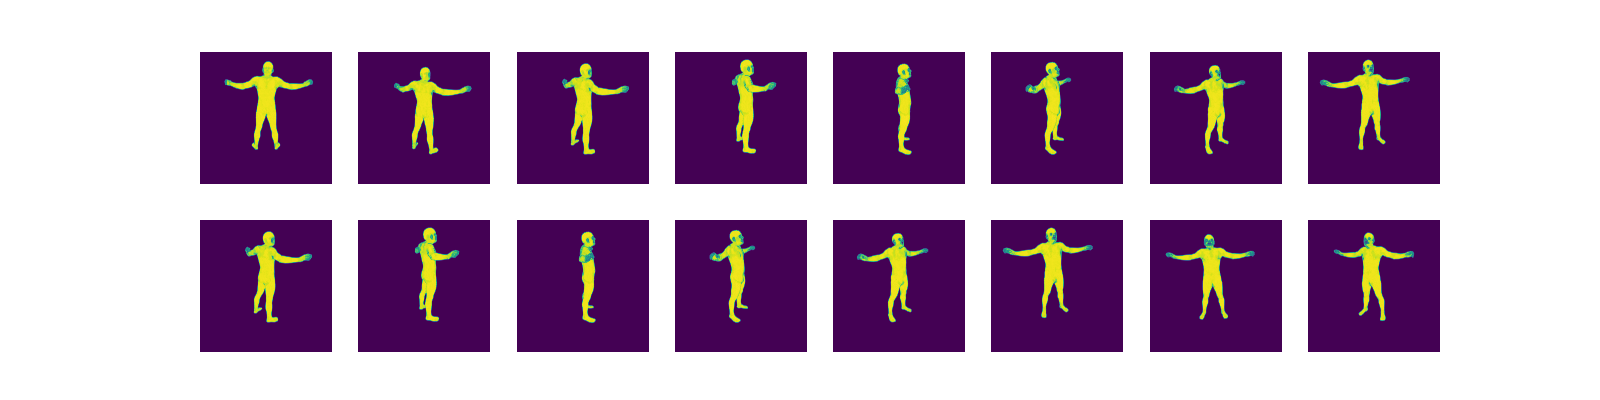

Before release: active_bytes.all.current: 77.477888 MB
After release: active_bytes.all.current: 77.477888 MB


In [23]:
visualize2DResults(images)
showCudaMemUsage(device)

In [24]:
diffImages = []
loss = 0
for iCam in range(len(cams)):
    imgDiff = np.abs(images[iCam] - imagesRef[iCam])
    diffImages.append(imgDiff)
    
    loss += 1 -np.sum(np.abs(images[iCam][..., 3] * imagesRef[iCam][..., 3])) / np.sum(np.abs(imagesRef[iCam][..., 3] + images[iCam][..., 3] - imagesRef[iCam][..., 3] * images[iCam][..., 3]))

In [25]:
a = np.array([[2,2], [2,2]])
print(np.linalg.norm(a.flatten(), ord=1))

8.0


<IPython.core.display.Javascript object>


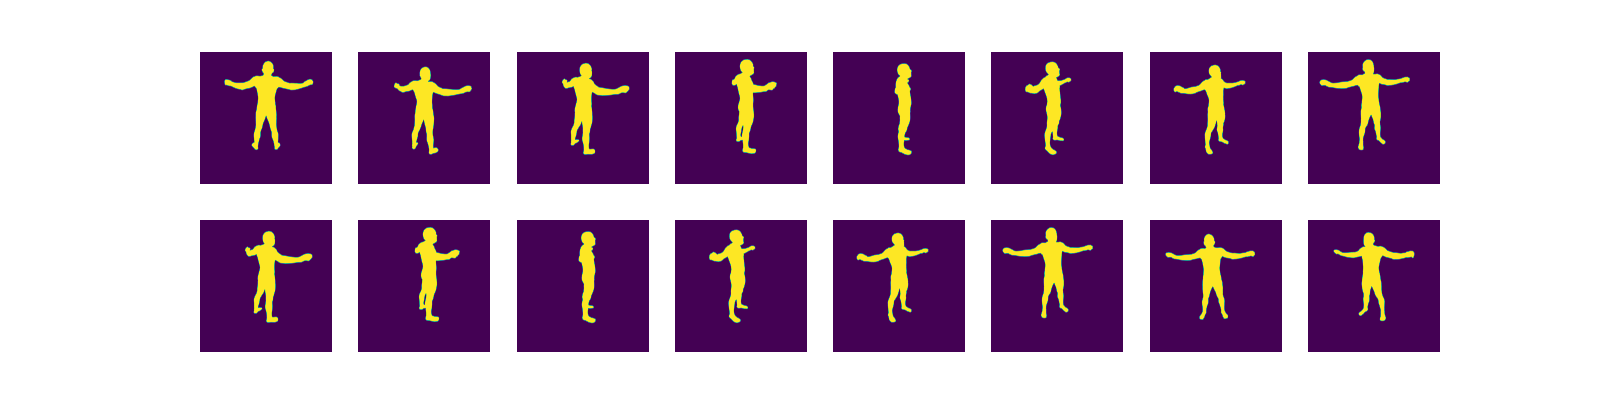

In [26]:
visualize2DResults(imagesRef, outImgFile = join(outFolderForExperiment, 'Target.png'))

<IPython.core.display.Javascript object>


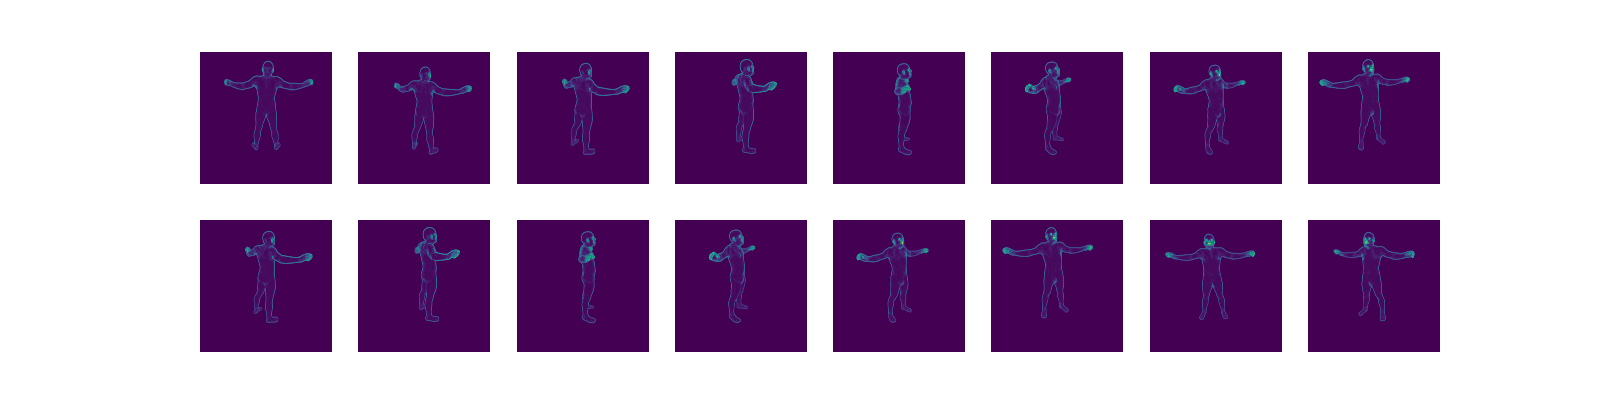

In [27]:
visualize2DResults(diffImages)

In [31]:
# with torch.no_grad():
#     loss = torch.sum((imageRef[..., 3] - image[..., 3]) ** 2)
# print('Inital loss:', loss)
poses = []
losses = []

In [32]:
cfg.learningRate = 0.05
cfg.learningRate = 3

optimizer = torch.optim.Adam([normalShift], lr=cfg.learningRate)

logFile = join(outFolderForExperiment, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [33]:
torch.cuda.empty_cache()
showCudaMemUsage(device)


Before release: active_bytes.all.current: 77.477888 MB
After release: active_bytes.all.current: 77.477888 MB


In [1]:
loop = tqdm_notebook(range(cfg.numIterations))
for i in loop:
    optimizer.zero_grad()
#     torch.cuda.empty_cache()

    lossVal = 0
    for iCam in range(cfg.numCams):
        refImg = torch.tensor(imagesRef[iCam][..., 3], dtype=torch.float64, device=device, requires_grad=False)
        modifiedVerts = verts + normalShift * nNormals
        mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
        
        images = renderSynth.renderer(mesh, cameras=cams[iCam])
#         print(images.requires_grad)
#         print(modifiedVerts.requires_grad)
        loss = 1 - torch.norm(refImg * images[..., 3], p=1) / torch.norm(refImg + images[..., 3] - refImg * images[..., 3], p=1)
        loss.backward()
        lossVal += loss.item()
        torch.cuda.empty_cache()
        #showCudaMemUsage(device)

    # targetImg = images[0, ..., :3]
    # loss, _ = model()
    
    # recordData
    losses.append(lossVal)
    
    optimizer.step()
    memStats = torch.cuda.memory_stats(device=device)
    memAllocated =  memStats['active_bytes.all.current'] / 1000000
    
    dis3D = modifiedVerts.cpu().detach().numpy() - modifiedVertsRef.cpu().numpy()
    dis3D = np.mean(np.sqrt(dis3D[:,0]**2 + dis3D[:,1]**2 + dis3D[:,2]**2))
    
    infoStr = 'loss %.2f, 3D Dis:  %.2fmm, shiftDiff: %.6f, MemUsed:%.2f' \
        % (lossVal, dis3D, torch.sum(torch.abs(normalShift - cfg.normalShiftLevel)).item(), memAllocated)
    
    loop.set_description(infoStr)
    logger.info(infoStr)
    
    #if lossVal < cfg.terminateLoss:
    #    break
    
    # Save outputs to create a GIF. 
    if i % cfg.plotStep == 0:
        showCudaMemUsage(device)
        modifiedVerts = verts + normalShift * nNormals
        mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
        
        torch.cuda.empty_cache()
        plt.close('all')
        
        outImgFile = join(outFolderForExperiment, 'Fig_' + str(i).zfill(5) + '.png')
        diffImages = []
        with torch.no_grad():
            for iCam in range(len(cams)):
                image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
#                 images.append(image_cur.cpu().detach().numpy())
                imgDiff = np.abs(image_cur.cpu().detach().numpy() - imagesRef[iCam])
                diffImages.append(imgDiff)
                torch.cuda.empty_cache()

#             showCudaMemUsage(device)
        visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
        
        saveVTK(join(outFolderMesh, 'Fit' + str(i).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)


NameError: name 'tqdm_notebook' is not defined

In [29]:
diffImages[0].shape

(1, 2160, 2160, 4)

In [ ]:
np.max(diffImages[0])

Before release: active_bytes.all.current: 189.534208 MB
After release: active_bytes.all.current: 189.534208 MB


<IPython.core.display.Javascript object>


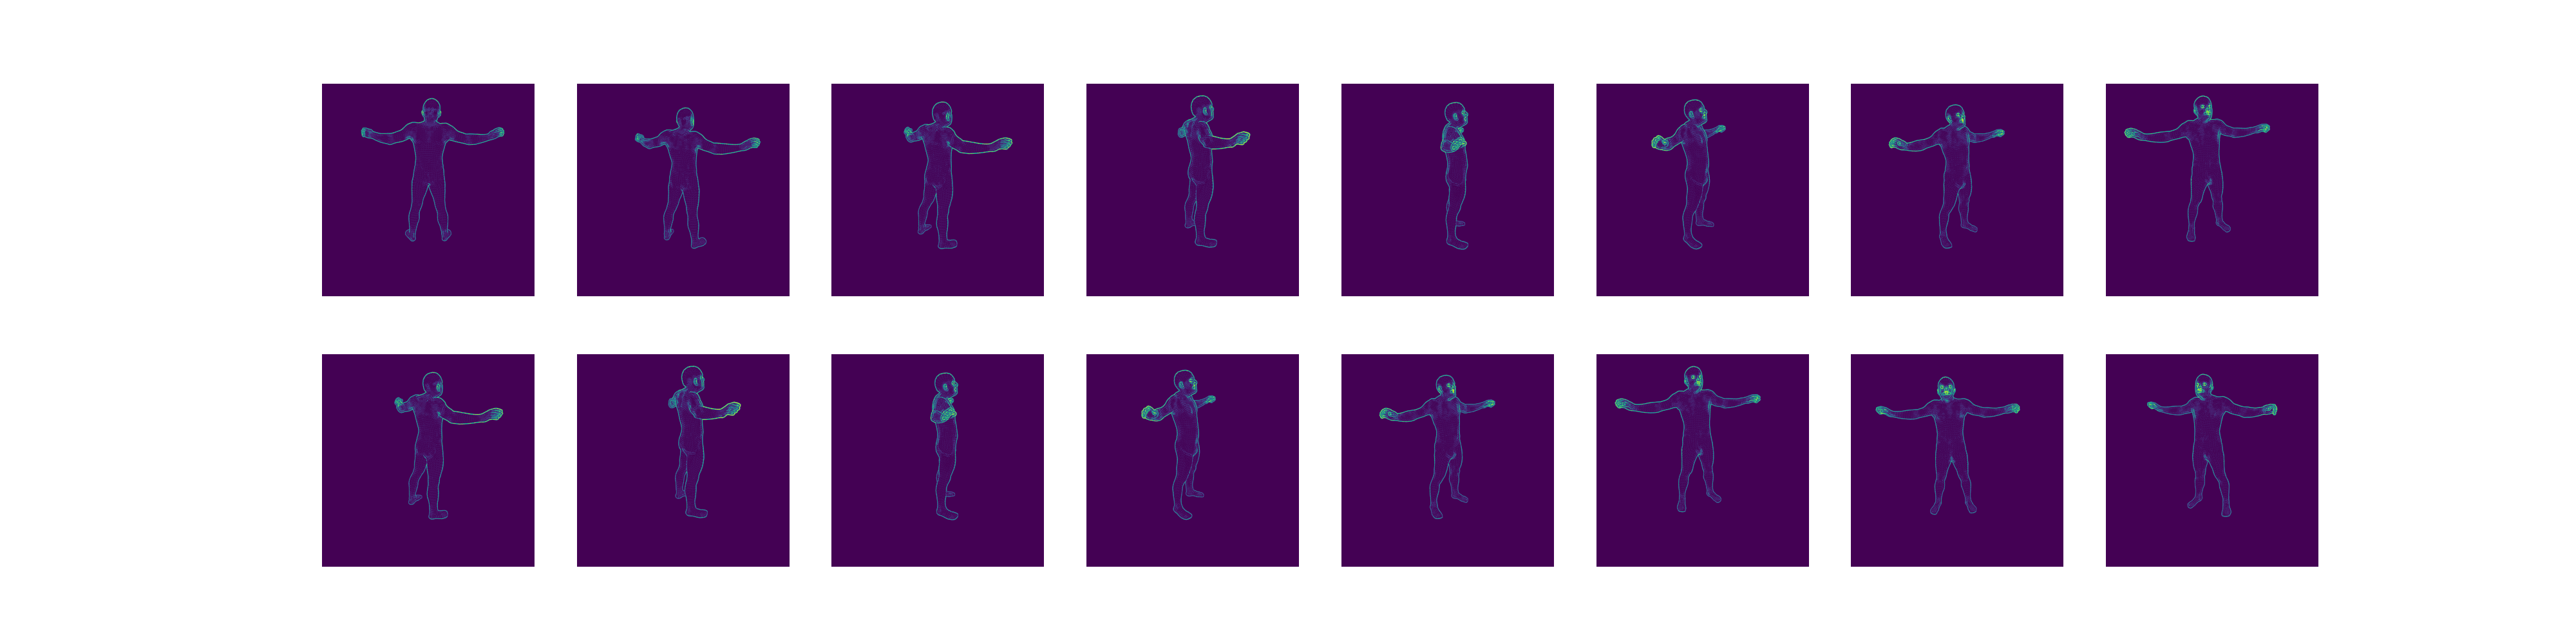

In [47]:
if True:
    showCudaMemUsage(device)
    modifiedVerts = verts + normalShift * nNormals
    mesh = Meshes(
            verts=[modifiedVerts],   
            faces=[faces_idx], 
        )
    
    torch.cuda.empty_cache()
    plt.close('all')
    
    outImgFile = join(outFolderForExperiment, 'Fig_' + str(0).zfill(5) + '.png')
    diffImages = []
    with torch.no_grad():
        for iCam in range(len(cams)):
            image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
            imgDiff =  np.abs(image_cur.cpu().detach().numpy() - imagesRef[iCam])
            diffImages.append(imgDiff)
    visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
    
    saveVTK(join(outFolderMesh, 'Fit' + str(0).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)